> __Purpose:__ This NB tests KNN in the agglomerative model clustering procedure

In [1]:
model_str = "KNN"
num_neighbors = 1

In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage

from moments_engr import *
from agglo_model_clust import *

In [3]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)
 

In [4]:
print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


 As a preliminary step, we can simulate each user training a gesture classification model using solely their own dataset. We can then execute a pairwise comparison, where we test each user’s model and every other user’s dataset, and report the score. At this point, we can begin a agglomerative clustering procedure, by either clustering the two users with the highest corresponding scores, or by clustering all users that achieved above some minimum cross-subject classification accuracy. Then, we can repeat this procedure on the newly formed clusters, this time training a single model over all the data in the given cluster. By repeating this process until only one model remains, we can generate a dendrogram showing which users are best clustered in order to train cluster-level models. One issue with this approach is that as the clusters grow, the training sets will grow in tandem. To a limited extent, this can be offset by limiting all dataset sizes to the size of single user’s dataset and having the cluster model train on a random sample of gestures. An alternative approach would be to enforce all users into clusters of the same size each round, so that all clusters have the same dataset size, although this would artificially create many clusters. However, we also expect to have the opposite problem, as in myprevious works I have shown that cross-subject models typically perform poorly in general for these types of tasks, e.g. that training over multiple users will likely only grant modest improvements in performance, if any (especially if fixing the training dataset size). The goal of this procedure is to yield clusters for which the internal cluster model performs better than any of the intra-subject models within the cluster. Even if the internal cluster model does not outperform all intra-subject models, as long as it reduces the calibration / number of samples required from a novel user, this is still a success.

In [5]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [6]:
merge_log, intra_cluster_performance, cross_cluster_performance = agglo_merge_procedure(userdef_df, model_str, mhp_knn_k=num_neighbors, test_split_percent=0.5)

32 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


31 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


30 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


29 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


28 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


27 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


26 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


25 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


24 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


23 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


22 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


21 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


20 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


19 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


18 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


17 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


16 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


15 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


14 Clusters Remaining


C:\Users\kdmen\anaconda3\envs\fl_torch\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


13 Clusters Remaining
12 Clusters Remaining
11 Clusters Remaining
10 Clusters Remaining
9 Clusters Remaining
8 Clusters Remaining
7 Clusters Remaining
6 Clusters Remaining
5 Clusters Remaining
4 Clusters Remaining
3 Clusters Remaining
2 Clusters Remaining


In [7]:
merge_log

[(0, 24, 11, 0.42857142857142855, 32),
 (1, 19, 16, 0.41304347826086957, 33),
 (2, 2, 4, 0.38, 34),
 (3, 28, 23, 0.3541666666666667, 35),
 (4, 34, 20, 0.3333333333333333, 36),
 (5, 8, 18, 0.32653061224489793, 37),
 (6, 0, 14, 0.3220338983050847, 38),
 (7, 32, 5, 0.3125, 39),
 (8, 29, 9, 0.2857142857142857, 40),
 (9, 37, 7, 0.2777777777777778, 41),
 (10, 21, 25, 0.25925925925925924, 42),
 (11, 35, 12, 0.25, 43),
 (12, 40, 3, 0.2391304347826087, 44),
 (13, 42, 36, 0.23076923076923078, 45),
 (14, 45, 22, 0.24, 46),
 (15, 33, 6, 0.22916666666666666, 47),
 (16, 41, 15, 0.22807017543859648, 48),
 (17, 1, 13, 0.20833333333333334, 49),
 (18, 49, 31, 0.22, 50),
 (19, 46, 26, 0.20754716981132076, 51),
 (20, 30, 10, 0.2037037037037037, 52),
 (21, 44, 39, 0.19444444444444445, 53),
 (22, 53, 17, 0.25, 54),
 (23, 47, 52, 0.15841584158415842, 55),
 (24, 55, 38, 0.1650485436893204, 56),
 (25, 50, 27, 0.15517241379310345, 57),
 (26, 57, 54, 0.15088757396449703, 58),
 (27, 58, 56, 0.1396011396011396, 59

## INTRA CLUSTER RESULTS

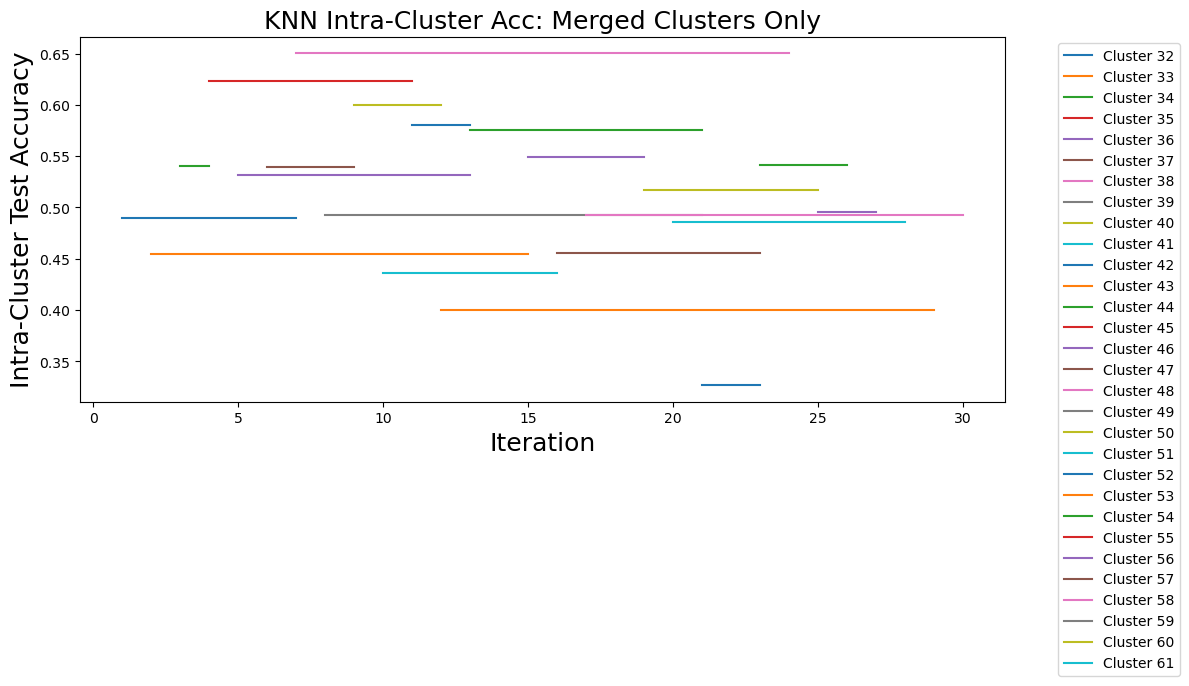

In [8]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc: Merged Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

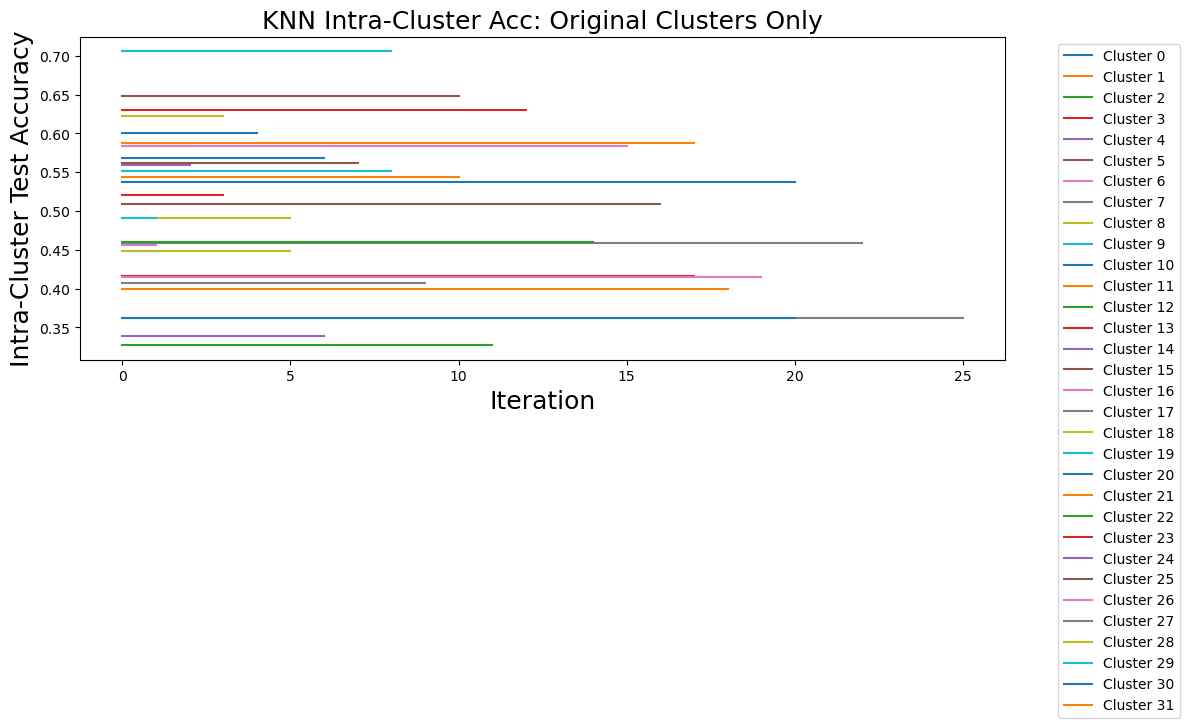

In [9]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc: Original Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## CROSS CLUSTER RESULTS

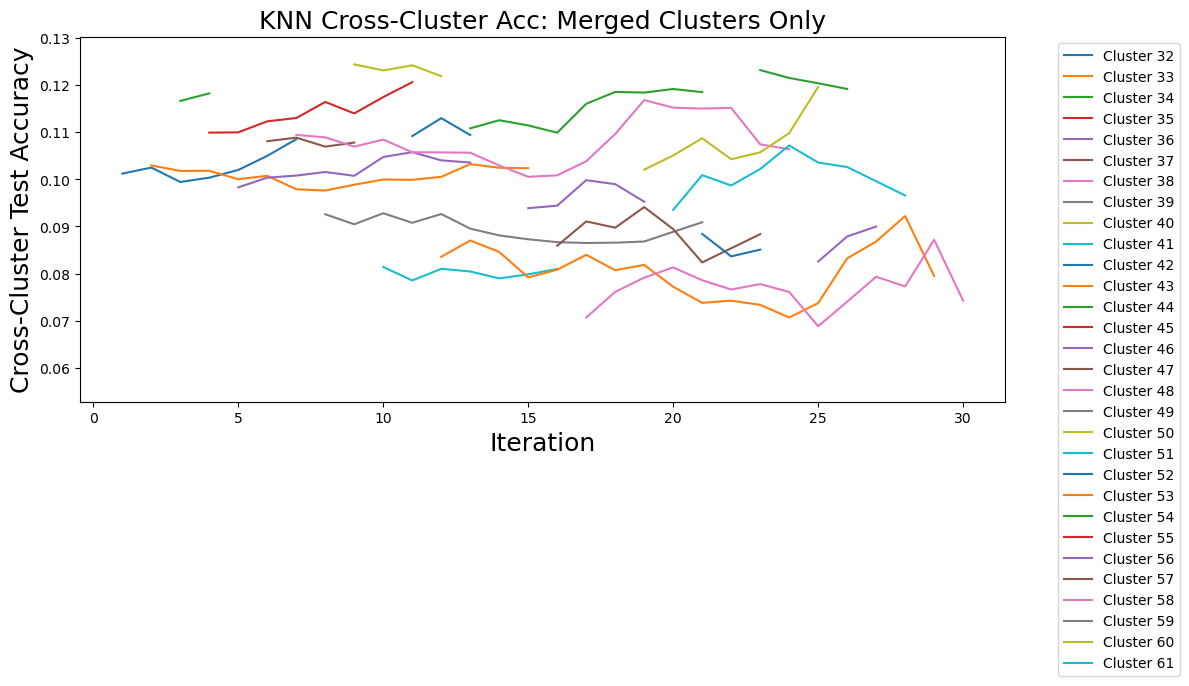

In [10]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc: Merged Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

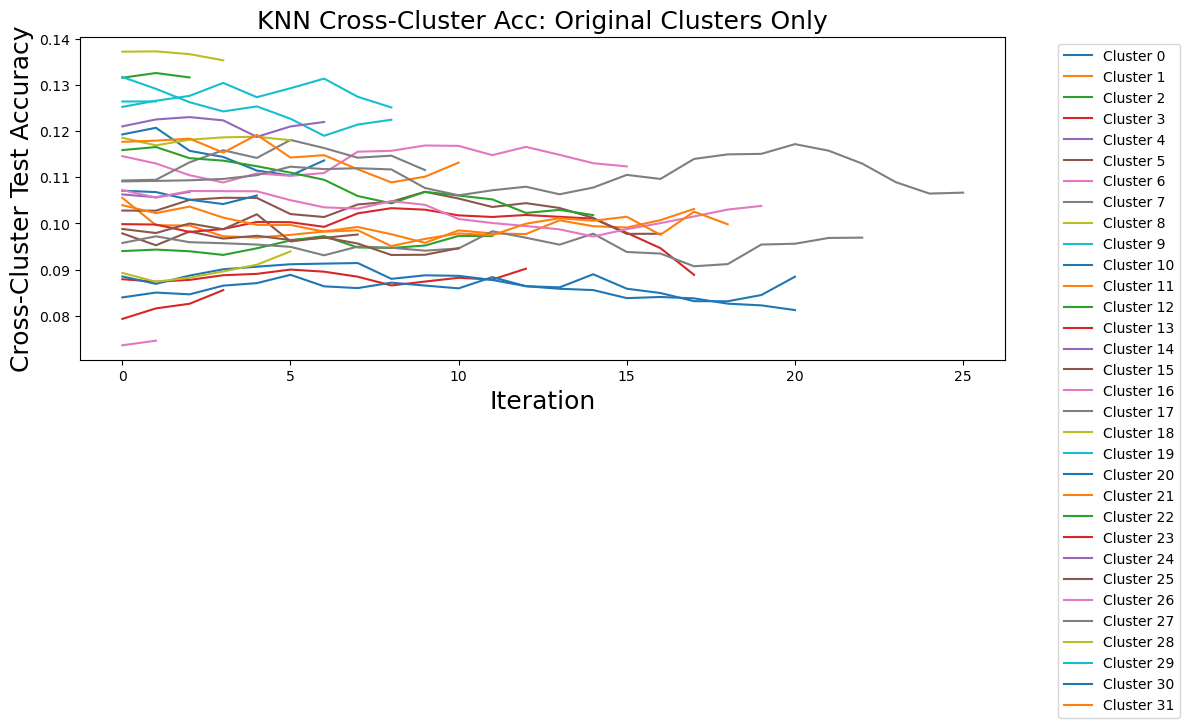

In [11]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc: Original Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

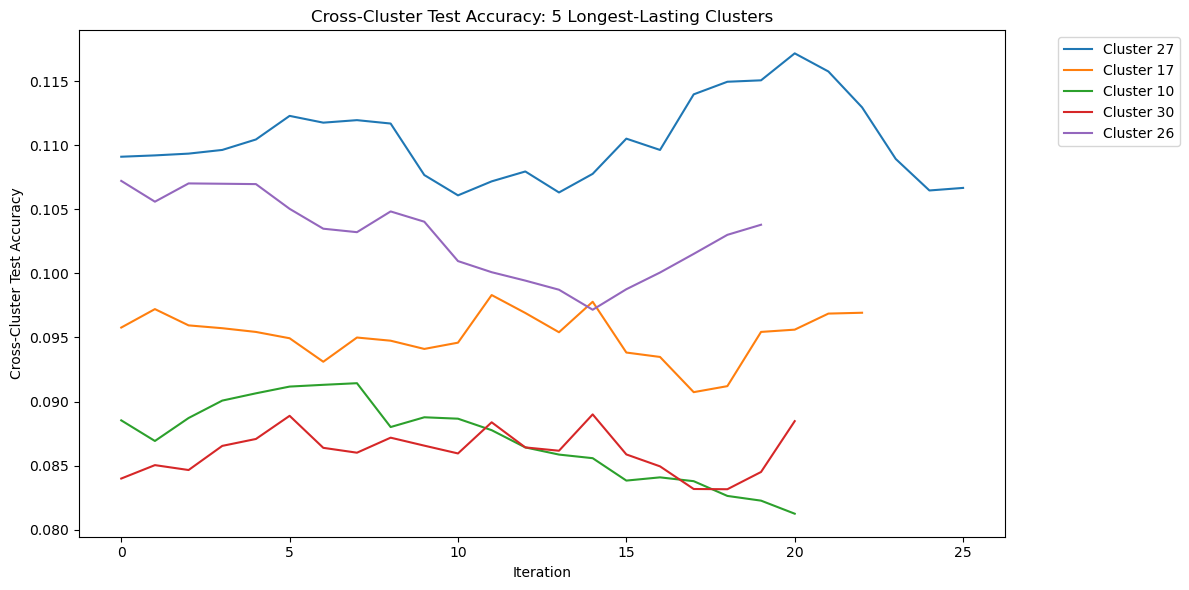

In [12]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5

# Reduce number of lines (e.g., top n longest-lived clusters)
longest_clusters = sorted(cross_cluster_performance.keys(), key=lambda k: len(cross_cluster_performance[k]), reverse=True)[:n]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

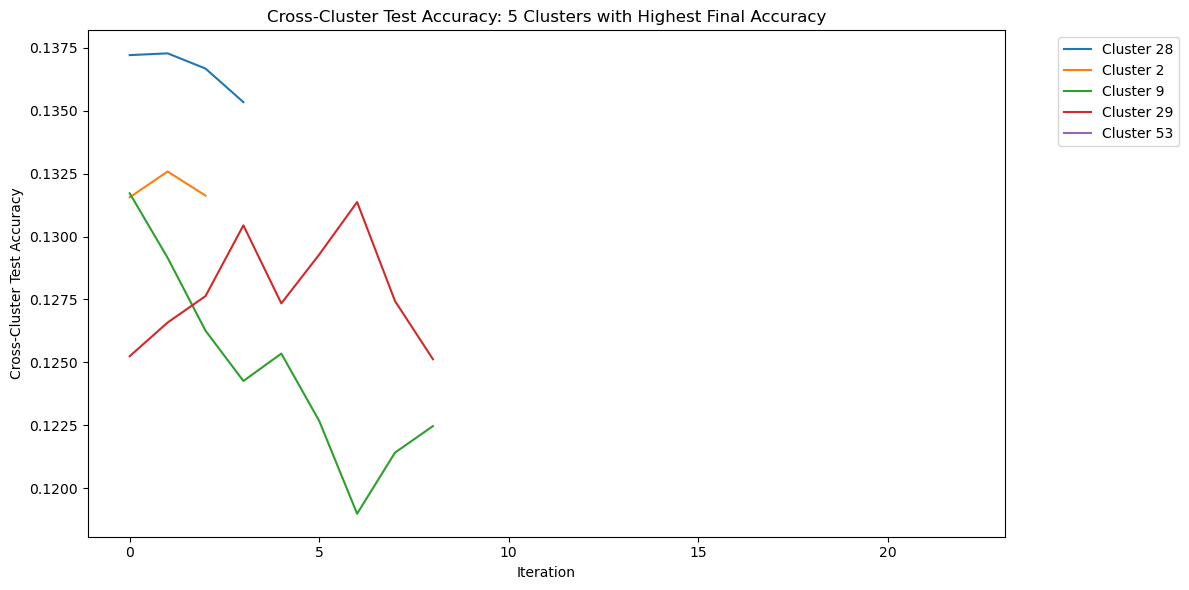

In [13]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5  # Number of clusters to plot

# Find clusters with the highest final accuracies
highest_final_accuracy_clusters = sorted(
    cross_cluster_performance.keys(), 
    key=lambda k: max([perf for it, perf in cross_cluster_performance[k] if perf is not None], default=0), 
    reverse=True
)[:n]

# Plot the performance curves for these clusters
for cluster_id in highest_final_accuracy_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Clusters with Highest Final Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Intra-Cluster Test Accuracy Merge Tracking

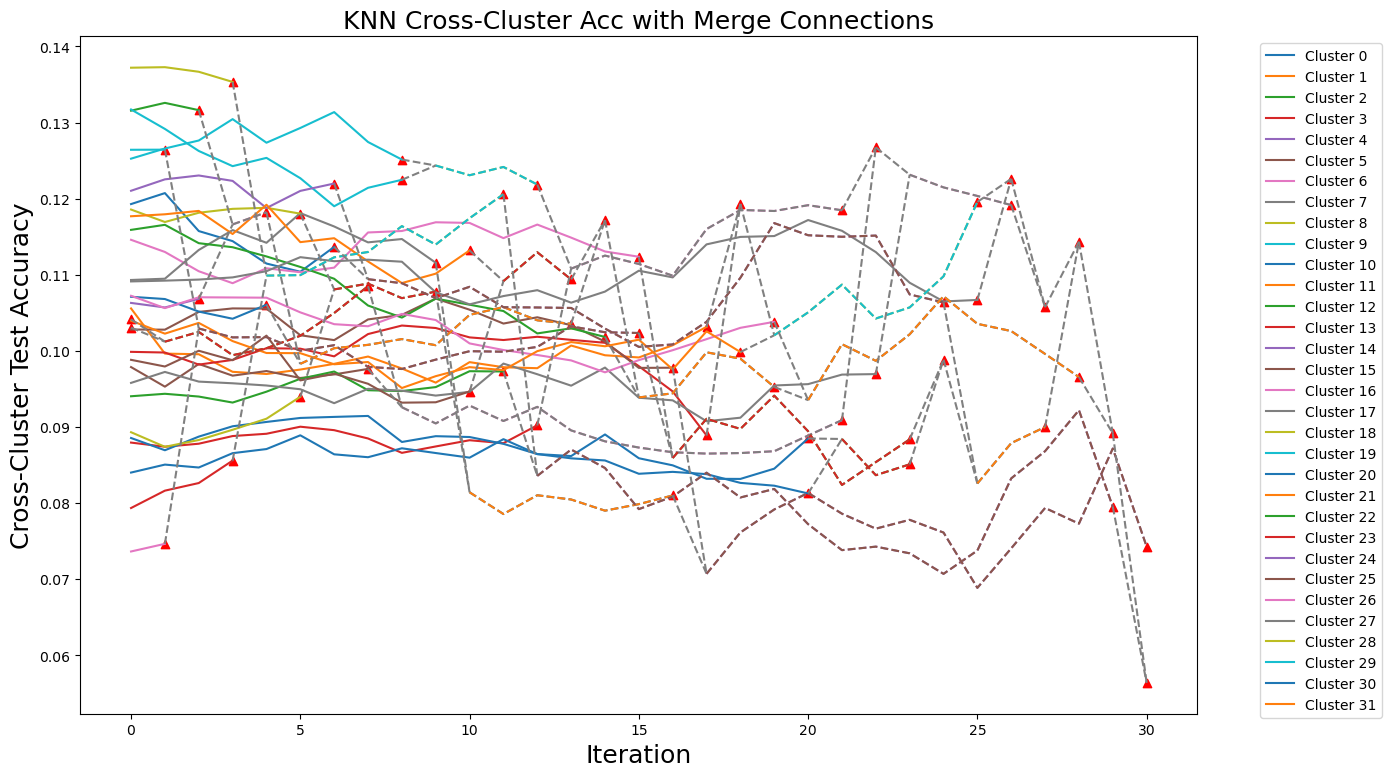

In [14]:
# Visualization with Merge Log and Connections
plt.figure(figsize=(14, 8))

# Dictionary to track the last valid point for each cluster
last_points = {}

# Plot original clusters
for cluster_id in cross_cluster_performance:
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0] != 0:
        continue

    # Plot original cluster performance
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")
    last_points[cluster_id] = (valid_iterations[-1], valid_performance[-1])  # Store the last point

# Handle merged clusters and connect original clusters
for iteration, cluster1, cluster2, _, new_cluster in merge_log:
    # Plot and connect the merged clusters
    for cluster in [cluster1, cluster2]:
        if cluster in cross_cluster_performance:
            data = cross_cluster_performance[cluster]
            merge_perf = next((perf for it, perf in data if it == iteration), None)
            if merge_perf is not None:
                plt.scatter(iteration, merge_perf, color='red', marker='^')#, label=f"Merge {cluster} → {new_cluster}")
                
        if cluster in last_points:  # If it's an original cluster
            last_iteration, last_perf = last_points[cluster]

            # Connect to the newly merged cluster
            if new_cluster in cross_cluster_performance:
                new_data = cross_cluster_performance[new_cluster]
                valid_iterations = [it for it, perf in new_data if perf is not None and it >= iteration]
                valid_performance = [perf for it, perf in new_data if perf is not None and it >= iteration]

                if valid_iterations:
                    # Draw a line connecting the original cluster to the new merged cluster
                    plt.plot(
                        [last_iteration, valid_iterations[0]],
                        [last_perf, valid_performance[0]],
                        linestyle='--', color='gray'
                    )

                    # Continue plotting the merged cluster's performance
                    plt.plot(valid_iterations, valid_performance, linestyle='--')

                # Update the last points for the newly merged cluster
                if valid_iterations:
                    last_points[new_cluster] = (valid_iterations[-1], valid_performance[-1])

# Add labels, legend, and formatting
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc with Merge Connections", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


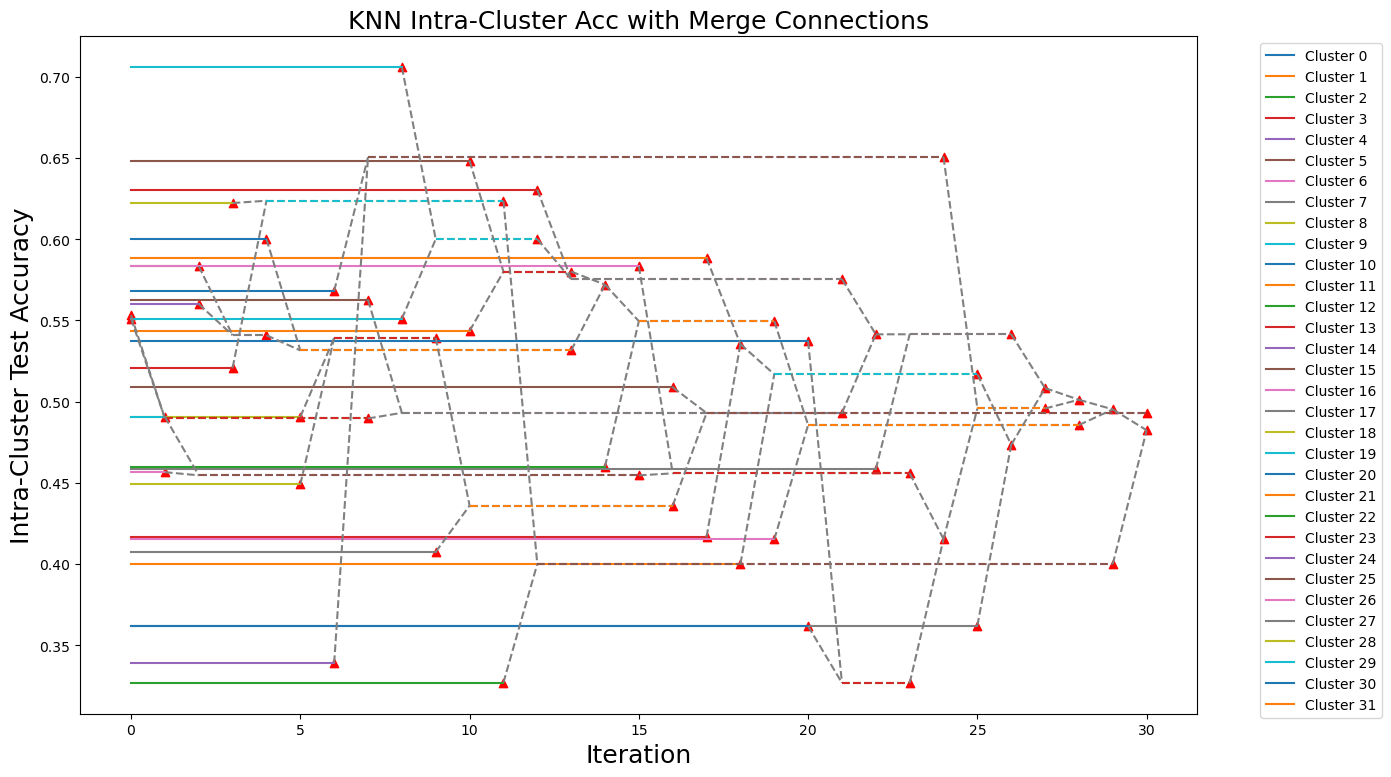

In [15]:
# Visualization with Merge Log and Connections
plt.figure(figsize=(14, 8))

# Dictionary to track the last valid point for each cluster
last_points = {}

# Plot original clusters
for cluster_id in intra_cluster_performance:
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0] != 0:
        continue

    # Plot original cluster performance
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")
    last_points[cluster_id] = (valid_iterations[-1], valid_performance[-1])  # Store the last point

# Handle merged clusters and connect original clusters
for iteration, cluster1, cluster2, _, new_cluster in merge_log:
    # Plot and connect the merged clusters
    for cluster in [cluster1, cluster2]:
        if cluster in intra_cluster_performance:
            data = intra_cluster_performance[cluster]
            merge_perf = next((perf for it, perf in data if it == iteration), None)
            if merge_perf is not None:
                plt.scatter(iteration, merge_perf, color='red', marker='^')#, label=f"Merge {cluster} → {new_cluster}")
                
        if cluster in last_points:  # If it's an original cluster
            last_iteration, last_perf = last_points[cluster]

            # Connect to the newly merged cluster
            if new_cluster in intra_cluster_performance:
                new_data = intra_cluster_performance[new_cluster]
                valid_iterations = [it for it, perf in new_data if perf is not None and it >= iteration]
                valid_performance = [perf for it, perf in new_data if perf is not None and it >= iteration]

                if valid_iterations:
                    # Draw a line connecting the original cluster to the new merged cluster
                    plt.plot(
                        [last_iteration, valid_iterations[0]],
                        [last_perf, valid_performance[0]],
                        linestyle='--', color='gray'
                    )

                    # Continue plotting the merged cluster's performance
                    plt.plot(valid_iterations, valid_performance, linestyle='--')

                # Update the last points for the newly merged cluster
                if valid_iterations:
                    last_points[new_cluster] = (valid_iterations[-1], valid_performance[-1])

# Add labels, legend, and formatting
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc with Merge Connections", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
intra_mean_lst, cross_mean_lst, ratio_lst = compute_performance_ratios(intra_cluster_performance, cross_cluster_performance)



=== Performance Ratios ===
Cluster 0: Intra Mean = 0.568, Cross Mean = 0.115, Ratio = 4.937
Cluster 1: Intra Mean = 0.588, Cross Mean = 0.099, Ratio = 5.933
Cluster 2: Intra Mean = 0.583, Cross Mean = 0.132, Ratio = 4.422
Cluster 3: Intra Mean = 0.630, Cross Mean = 0.088, Ratio = 7.131
Cluster 4: Intra Mean = 0.560, Cross Mean = 0.106, Ratio = 5.270
Cluster 5: Intra Mean = 0.562, Cross Mean = 0.097, Ratio = 5.796
Cluster 6: Intra Mean = 0.583, Cross Mean = 0.113, Ratio = 5.141
Cluster 7: Intra Mean = 0.407, Cross Mean = 0.114, Ratio = 3.583
Cluster 8: Intra Mean = 0.491, Cross Mean = 0.118, Ratio = 4.151
Cluster 9: Intra Mean = 0.551, Cross Mean = 0.125, Ratio = 4.419
Cluster 10: Intra Mean = 0.537, Cross Mean = 0.087, Ratio = 6.170
Cluster 11: Intra Mean = 0.551, Cross Mean = 0.104, Ratio = 5.292
Cluster 12: Intra Mean = 0.327, Cross Mean = 0.095, Ratio = 3.432
Cluster 13: Intra Mean = 0.417, Cross Mean = 0.100, Ratio = 4.181
Cluster 14: Intra Mean = 0.339, Cross Mean = 0.122, Ratio 

Text(0.5, 1.0, 'KNN Summary Statistic Trends')

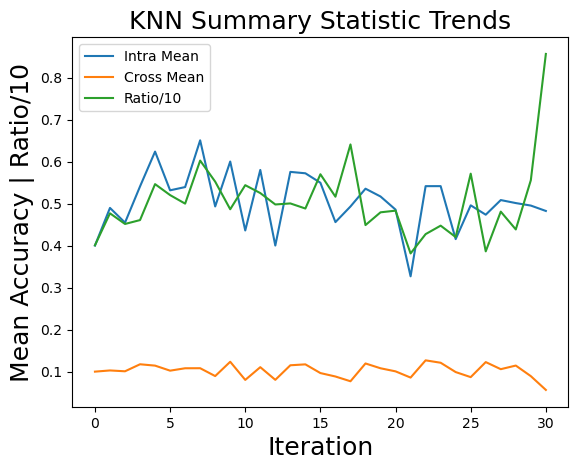

In [17]:
plt.plot(intra_mean_lst[31:], label="Intra Mean")
plt.plot(cross_mean_lst[31:], label="Cross Mean")
plt.plot((np.array(ratio_lst)/10)[31:], label="Ratio/10")
plt.legend(loc='upper left')
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Mean Accuracy | Ratio/10", fontsize=18)
plt.title(f"{model_str} Summary Statistic Trends", fontsize=18)